In [14]:
# multigrid_gnn_multires_physics.py
"""
Physics-informed Multigrid + GNN eigen-refinement
- Exact solve only on coarsest mesh
- Multiresolution GNN with residual + orthonormality + projection loss
- Coarse-to-fine prolongation only
"""

import os
import numpy as np
from scipy.linalg import eigh
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from Mesh import Mesh
import robust_laplacian

# ------------------------
# Utilities
# ------------------------
def sp_to_torch_sparse(A):
    A = A.tocoo()
    indices = np.vstack((A.row, A.col)).astype(np.int64)
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(A.data)
    return torch.sparse_coo_tensor(i, v, A.shape).coalesce()

def normalize_columns_np(U, eps=1e-12):
    norms = np.linalg.norm(U, axis=0) + eps
    return U / norms, norms

def normalize_columns_torch(U, eps=1e-12):
    norms = torch.norm(U, dim=0) + eps
    return U / norms, norms

def farthest_point_sampling(points, n_samples, seed=None):
    """
    Farthest Point Sampling (FPS) for nested hierarchical sampling.
    
    Args:
        points: (N, 3) array of 3D points
        n_samples: number of points to sample
        seed: random seed for initial point selection
    
    Returns:
        indices: (n_samples,) array of selected point indices
    """
    n_points = points.shape[0]
    if n_samples >= n_points:
        return np.arange(n_points)
    
    rng = np.random.default_rng(seed=seed)
    
    # Start with a random point
    selected_indices = [rng.integers(0, n_points)]
    distances = np.full(n_points, np.inf)
    
    for _ in range(n_samples - 1):
        # Update distances to nearest selected point
        last_selected = selected_indices[-1]
        dists_to_last = np.linalg.norm(points - points[last_selected], axis=1)
        distances = np.minimum(distances, dists_to_last)
        
        # Select point farthest from all selected points
        farthest_idx = np.argmax(distances)
        selected_indices.append(farthest_idx)
    
    return np.array(selected_indices)

# ------------------------
# Simple neighbor-mean corrector
# ------------------------
class SimpleCorrector(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_sizes=(128,64,32), dropout=0.0):
        super().__init__()
        layers = []
        prev = in_dim * 2
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU(inplace=True))
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, edge_index):
        row, col = edge_index
        n = x.shape[0]
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        deg = torch.bincount(row, minlength=n).unsqueeze(1).to(x.dtype).to(x.device).clamp(min=1.0)
        agg = agg / deg
        h = torch.cat([x, agg], dim=1)
        return self.net(h)

# ------------------------
# Multigrid GNN solver
# ------------------------
class MultigridGNN:
    def __init__(self, device=None, checkpoint_dir="./checkpoints"):
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        self.model = None
        self.checkpoint_dir = checkpoint_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    @staticmethod
    def normalize_mesh(mesh):
        centroid = mesh.verts.mean(0)
        std_max = mesh.verts.std(0).max() + 1e-12
        verts_normalized = (mesh.verts - centroid) / std_max
        return Mesh(verts=verts_normalized, connectivity=mesh.connectivity)

    @staticmethod
    def build_prolongation(X_coarse, X_fine, k=1):
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X_coarse)
        distances, indices = nbrs.kneighbors(X_fine)
        n_fine, n_coarse = X_fine.shape[0], X_coarse.shape[0]
        rows, cols, vals = [], [], []
        for i in range(n_fine):
            weights = 1.0 / (distances[i] + 1e-12)
            weights /= weights.sum()
            for j, idx in enumerate(indices[i]):
                rows.append(i)
                cols.append(idx)
                vals.append(weights[j])
        return coo_matrix((vals, (rows, cols)), shape=(n_fine, n_coarse))

    @staticmethod
    def build_knn_graph(X, k=4):
        n_points = X.shape[0]
        nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
        _, neighbors = nbrs.kneighbors(X)
        rows, cols = [], []
        for i in range(n_points):
            for j in neighbors[i][1:]:
                rows.append(i)
                cols.append(j)
        return torch.LongTensor([rows, cols]).to(torch.long)

    def solve_eigenvalue_problem(self, X, n_modes):
        L, M = robust_laplacian.point_cloud_laplacian(X)
        vals, vecs = eigsh(L, k=n_modes, M=M, which='SM')
        return vals, np.array(vecs), L, M

    # ------------------------
    # Physics-informed GNN training
    # ------------------------
    def train_multiresolution(self, X_list, U_init_list, edge_index_list,
                              epochs=1000, lr=1e-3, corr_scale=1e-2,
                              w_res=5.0, w_orth=50.0, w_proj=1e-2,
                              grad_clip=1.0, weight_decay=1e-6, log_every=250):
        device = self.device
        n_modes = U_init_list[0].shape[1]

        # Build torch tensors and resolution indicators
        x_feats_all, U_all, edge_index_all = [], [], []
        node_offset = 0
        max_nodes = max([X.shape[0] for X in X_list])
        for X, U_init, edge_index in zip(X_list, U_init_list, edge_index_list):
            res_feat = np.full((X.shape[0], 1), X.shape[0]/max_nodes)
            x_feats_all.append(np.hstack([X, U_init, res_feat]))
            U_all.append(U_init)
            edge_index_all.append(edge_index + node_offset)
            node_offset += X.shape[0]

        x_feats_all = torch.FloatTensor(np.vstack(x_feats_all)).to(device)
        U_all_tensor = torch.FloatTensor(np.vstack(U_all)).to(device)
        edge_index_all = torch.cat(edge_index_all, dim=1).to(device)

        in_dim = x_feats_all.shape[1]
        if self.model is None:
            self.model = SimpleCorrector(in_dim, n_modes).to(device)

        optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=lr, weight_decay=weight_decay)
        self.model.train()

        # ------------------------
        # Precompute Laplacians per level
        L_list, M_list = [], []
        node_offset = 0
        for X in X_list:
            L, M = robust_laplacian.point_cloud_laplacian(X)
            L_list.append(sp_to_torch_sparse(L).to(device))
            M_list.append(sp_to_torch_sparse(M).to(device))

        for ep in range(epochs):
            optimizer.zero_grad()
            corr_raw = self.model(x_feats_all, edge_index_all)
            corr = corr_scale * corr_raw
            U_pred = U_all_tensor + corr

            # Physics-informed loss
            loss = 0.0
            node_offset = 0
            L_res_total = 0.0
            L_orth_total = 0.0
            L_mean_total = 0.0
            
            for i, (L_t, M_t, U_init) in enumerate(zip(L_list, M_list, U_init_list)):
                n_nodes = U_init.shape[0]
                U_level = U_pred[node_offset:node_offset+n_nodes]

                # Rayleigh residual
                Lu = torch.sparse.mm(L_t, U_level)
                Mu = torch.sparse.mm(M_t, U_level)
                num = torch.sum(U_level * Lu, dim=0)
                den = torch.sum(U_level * Mu, dim=0) + 1e-12
                lambdas = num / den
                res = Lu - Mu * lambdas.unsqueeze(0)
                L_res = torch.mean(res**2)
                
                # Orthonormality
                Gram = U_level.t() @ Mu
                L_orth = torch.mean((Gram - torch.eye(n_modes, device=device))**2)

                # Zero-mean constraint: 1.T @ M @ u = 0 for modes 1 onwards
                ones = torch.ones(n_nodes, 1, device=device)
                mean_constraint = ones.t() @ Mu[:, 1:]  # Shape: (1, n_modes-1)
                L_mean = torch.mean(mean_constraint**2)

                loss += w_res * L_res + w_orth * L_orth + w_proj * L_mean
                node_offset += n_nodes

            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, self.model.parameters()), grad_clip)
            optimizer.step()

            if ep % log_every == 0 or ep == epochs-1:
                print(f"Epoch {ep:4d}: Loss={loss.item():.6f} | Res={L_res.item():.6f} | Orth={L_orth.item():.6f} | Mean={L_mean.item():.6f}")

        return U_pred.detach().cpu().numpy()

    # ------------------------
    # Rayleigh-Ritz refinement
    # ------------------------
    def refine_eigenvectors(self, U_pred, L, M):
        U = torch.FloatTensor(U_pred).to(self.device)
        L_t = sp_to_torch_sparse(L).to(self.device)
        M_t = sp_to_torch_sparse(M).to(self.device)
        A = (U.t() @ torch.sparse.mm(L_t, U)).cpu().numpy()
        B = (U.t() @ torch.sparse.mm(M_t, U)).cpu().numpy()
        vals, C = eigh(A, B)
        U_refined = U.cpu().numpy() @ C
        return vals, U_refined
    

def visualize_mesh(mesh, title='Mesh Visualization', highlight_indices=None):
    """Visualize mesh with vertices, optionally highlighting specific points."""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    
    # Plot full mesh with transparency
    ax.plot_trisurf(mesh.verts[:, 0], mesh.verts[:, 1], mesh.verts[:, 2], 
                    triangles=mesh.connectivity, alpha=0.3)
    
    # Highlight specific points if provided
    if highlight_indices is not None:
        highlighted_verts = mesh.verts[highlight_indices]
        ax.scatter(highlighted_verts[:, 0], highlighted_verts[:, 1], highlighted_verts[:, 2], 
                   c='fuchsia', s=10, alpha=0.8, label=f'{len(highlight_indices)} selected points')
        ax.legend()
    
    ax.set_title(title)
    ax.view_init(elev=130, azim=-90)
    plt.show()


# ------------------------
# Main
# ------------------------
def main():
    mesh_path = "bunny.obj"
    n_modes = 64
    hierarchy = [128, 512, 1024]  # final level is full mesh
    k_neighbors = 4
    epochs = 5_000

    print("Loading mesh...")
    mesh = Mesh(mesh_path)
    mesh = MultigridGNN.normalize_mesh(mesh)
    X_full = mesh.verts
    n_total = X_full.shape[0]
    hierarchy = [n for n in hierarchy if n <= n_total]
    if hierarchy[-1] != n_total:
        hierarchy.append(n_total)
    print("Hierarchy:", hierarchy)

    # Use Farthest Point Sampling for nested hierarchy
    print("Computing farthest point sampling hierarchy...")
    all_sampled_indices = farthest_point_sampling(X_full, hierarchy[-1], seed=42)
    
    # Create nested levels by taking first n points from FPS result
    indices_per_level = {}
    for i, n_points in enumerate(hierarchy):
        indices_per_level[i] = all_sampled_indices[:n_points].copy()
        print(f"  Level {i}: {n_points} points (nested FPS)")
    

    #for level_idx_vis, n_points in enumerate(hierarchy):
    #    # Visualize selected points for this level
    #    visualize_mesh(mesh, 
    #                  title=f'Level {level_idx_vis}: {n_points} FPS Selected Points',
    #                  highlight_indices=indices_per_level[level_idx_vis])
    #print()

    solver = MultigridGNN()

    # ------------------------
    # Level 0: exact coarse solve
    # ------------------------
    idx0 = indices_per_level[0]
    X0 = X_full[idx0]
    print(f"\nLEVEL 0: exact solve on {X0.shape[0]} points...")
    lambda0, U0, L0, M0 = solver.solve_eigenvalue_problem(X0, n_modes)
    print("Coarse eigenvalues:", np.round(lambda0,6))

    # ------------------------
    # Coarse-to-fine prolongation
    # ------------------------
    U_prev = U0.copy()
    X_list, U_init_list, edge_index_list = [X0], [U0], [solver.build_knn_graph(X0, k=k_neighbors)]
    for level in range(1, len(hierarchy)):
        idx_coarse = indices_per_level[level-1]
        idx_fine = indices_per_level[level]
        Xc = X_full[idx_coarse]
        Xf = X_full[idx_fine]

        P = solver.build_prolongation(Xc, Xf, k=1)
        U_init = P @ U_prev
        edge_index = solver.build_knn_graph(Xf, k=k_neighbors)

        X_list.append(Xf)
        U_init_list.append(U_init)
        edge_index_list.append(edge_index)

        U_prev = U_init.copy()

    # ------------------------
    # Train physics-informed GNN
    # ------------------------
    print("\nTraining physics-informed multiresolution GNN...")
    U_pred_all = solver.train_multiresolution(X_list, U_init_list, edge_index_list,
                                              epochs=epochs)

    # ------------------------
    # Rayleigh-Ritz refinement per level
    # ------------------------
    node_offset = 0
    for level, X in enumerate(X_list):
        n_nodes = X.shape[0]
        U_pred = U_pred_all[node_offset:node_offset+n_nodes]
        node_offset += n_nodes
        L, M = robust_laplacian.point_cloud_laplacian(X)
        vals_refined, _ = solver.refine_eigenvectors(U_pred, L, M)
        print(f"Level {level} refined eigenvalues: {np.round(vals_refined,3)}")

    return U_pred

In [15]:
U_pred = main()

Loading mesh...
Hierarchy: [128, 512, 1024, 2503]
Computing farthest point sampling hierarchy...
  Level 0: 128 points (nested FPS)
  Level 1: 512 points (nested FPS)
  Level 2: 1024 points (nested FPS)
  Level 3: 2503 points (nested FPS)

LEVEL 0: exact solve on 128 points...
Coarse eigenvalues: [-0.        0.446669  0.931944  1.450187  1.657461  2.553185  3.398102
  3.599375  3.927035  4.400232  5.758432  6.158406  7.425521  7.710572
  8.420004  8.766825  9.59503  10.297442 10.541002 10.63585  11.222649
 12.406994 12.605034 13.092518 14.123055 14.471048 15.635345 16.238452
 16.311518 16.586656 17.944219 19.934578 20.876693 21.414534 23.4512
 24.938146 27.087583 28.279243 28.516698 29.58717  30.376741 31.409567
 31.727582 37.567104 38.159693 42.157319 42.934888 43.579741 52.455125
 55.148433 57.439542 58.14113  58.265278 63.754657 64.493111 67.02183
 71.60395  75.761796 79.792755 83.719883 84.267654 84.610403 87.986166
 95.366041]

Training physics-informed multiresolution GNN...
Epoc

In [18]:
import meshio

m = Mesh('bunny.obj')

centroid = m.verts.mean(0)
std_max = m.verts.std(0).max()

verts_new = (m.verts - centroid)/std_max

m = Mesh(verts = verts_new, connectivity = m.connectivity)
cells = [('triangle', m.connectivity)]

m_out = meshio.Mesh(m.verts, cells, point_data={f'v{i}': U_pred[:, i] for i in range(1, 64)})
m_out.write('bunny_eigfuncs_farthest_point_sampling.vtu')

In [7]:

print('Computing Laplacian')
K, M = m.computeLaplacian()
print('Computing eigen values')
eigvals, eigvecs = eigh(K,M)

Computing Laplacian
Computing eigen values


In [16]:
tmp_mat = U_pred.T @ M @ U_pred
tmp_ex  = eigvecs[:, :64].T @ M @ eigvecs[:, :64]

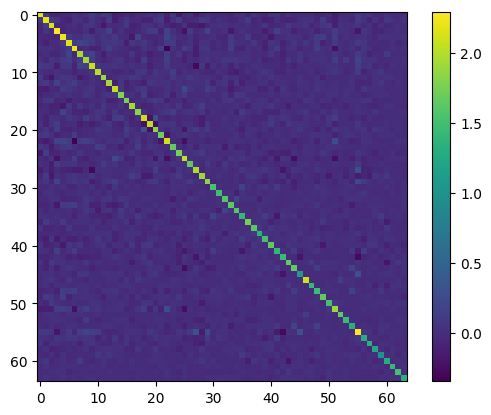

In [17]:
plt.imshow(tmp_mat)
plt.colorbar()

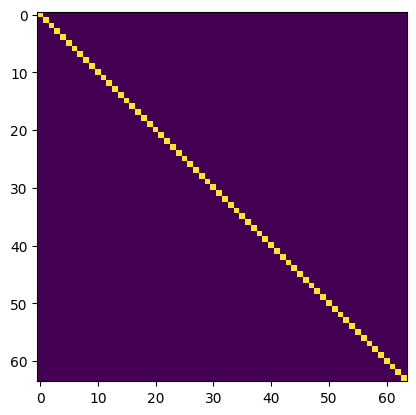

In [11]:
plt.imshow(tmp_ex)